In [43]:
import pandas as pd
import numpy as np
import mnist

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(0)

## Load the dataset

The MNIST database is available at http://yann.lecun.com/exdb/mnist/

The MNIST database is a dataset of handwritten digits. It has 60,000 training samples, and 10,000 test samples. Each image is represented by 28x28 pixels, each containing a value 0 - 255 with its grayscale value.

We will be using the `mnist` library to download images and labels from the MNIST database

The dataset is downloaded and cached in your temporary directory, so, calling the functions again, is much faster and doesn't hit the server.

In [44]:
import mnist

train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [45]:
print(f'train images shape: {train_images.shape}')
print(f'test images shape: {test_images.shape}')

train images shape: (60000, 28, 28)
test images shape: (10000, 28, 28)


## MNIST Images and labels

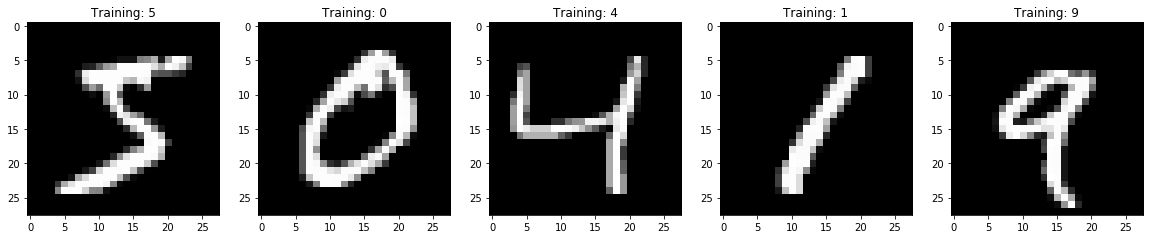

In [46]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(train_images[:5], train_labels[:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title(f'Training: {label}')

## Preprocessing

From the previous notebook, we noticed below few reasons for misclassification:

1. Numbers that are incomplete/have gaps (for example 0 got predicted as 5 because it had a gap) seem to be wrongly classified.
2. Blurry handwritten (by probably students), slanty digits and in few cases very fat digits seem to get misclassified. Probably train model with more blurry images, deslanted and deskewed images.

For each algorithm, we will use a couple of data preprocessing techniques listed below to see how the it performs, if there is an improvement in the error rate:

1.  Deskewing
2.  Noise removal
3.  Blurring
4.  N-pixel shift
5.  Shiftable edges
6.  Subsampling
7.  Shape context feature extraction
8.  Haar features
9.  Width normalization
10. Deslanting
11. None of the above

After deskewing, as a next step we could prioritize denoising. As we observed, most of the digits were fat or thin or noisy. Let us see how denoising makes a difference.

### Deskewing

When we write, we often write at angles to the paper, which cause letters and numbers to be skewed. Unfortunately, unlike the human eye, computers cannot easily find similarities between images that are transformations of each other. Thus, the process of deskewing. 

It is given by the formula: 
$ \begin{bmatrix} 1 & 1 \\ \alpha & 1 \end{bmatrix}$

where $\alpha = \frac {Cov(X,Y)}{Var(X)}$

Furthermore, we have an offset of  μ − center

Thus, combining the two, using the handy interpolation library from scipy, we complete the method deskew below.

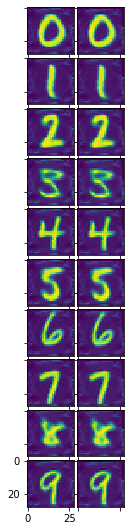

In [47]:
# Move to utils.py

from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

examples = (4181, 0), (3,1), (56282, 2), (25829,3), (9741,4) , (26901,5), (50027,6), (17935,7) , (41495, 8), (14662, 9)

from mpl_toolkits.axes_grid1 import AxesGrid
grid = AxesGrid(plt.figure(figsize=(8,15)), 141,  # similar to subplot(141)
                    nrows_ncols=(10, 2),
                    axes_pad=0.05,
                    label_mode="1",
                    )

for examplenum,num in examples:
    im = grid[2*num].imshow(train_min_max[examplenum].reshape(28,28))
    im2 = grid[2*num+1].imshow(deskew(train_min_max[examplenum].reshape(28,28)))

### Denoising

In [48]:
# https://keras.io/examples/mnist_denoising_autoencoder/

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from PIL import Image

np.random.seed(1337)

# MNIST dataset
(x_train, _), (x_test, _) = (train_images, train_labels), (test_images, test_labels)

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

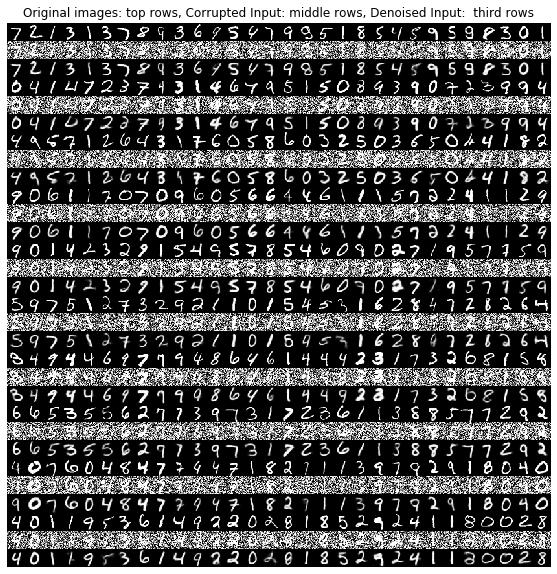

In [57]:
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

In [58]:
# Flatten images since the algorithm expects a 2d array
def flatten_images(images):
    n_samples, x_pixels, y_pixels = images.shape
    return images.reshape(n_samples, x_pixels*y_pixels)

def deskew_all(images):
    images_list = []
    for i in range(len(images)):
        images_list.append(deskew(images[i]))
    return np.array(images_list)

## Training and prediction using Logistic Regression

In [59]:
# denoise images
train_data_denoised = autoencoder.predict(x_train_noisy).reshape(-1, train_data_denoise.shape[1], train_data_denoise.shape[2])
test_data_denoised = autoencoder.predict(x_test_noisy).reshape(-1, train_data_denoise.shape[1], train_data_denoise.shape[2])

In [60]:
# deskew
train_data_deskewed_denoised = deskew_all(train_data_denoised)
test_data_deskewed_denoised = deskew_all(test_data_denoised)

# flatten
train_data = flatten_images(train_data_deskewed_denoised)
test_data = flatten_images(test_data_deskewed_denoised)

# Scale data using minmax scaler, as it is more suited for images.
min_max_scaler = preprocessing.MinMaxScaler()
train_min_max = min_max_scaler.fit_transform(train_data)
test_min_max = min_max_scaler.transform(test_data)

In [61]:
# move to utils.py
def print_classification_vector(coef):
    # Pick max value from the co-efficient matrix
    scale = np.abs(coef).max()
    
    plt.figure(figsize=(20, 10))
    for i in range(coef.shape[0]):
        plt.subplot(2, 5, i+1)
        plt.imshow(coef[i].reshape(28,28), interpolation='nearest',
                       cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)

Sparsity of the matrix: 77.15561224489797
Accuracy score with l1 penalty: 0.9133
Classification vectors.. None
Wall time: 21.9 s


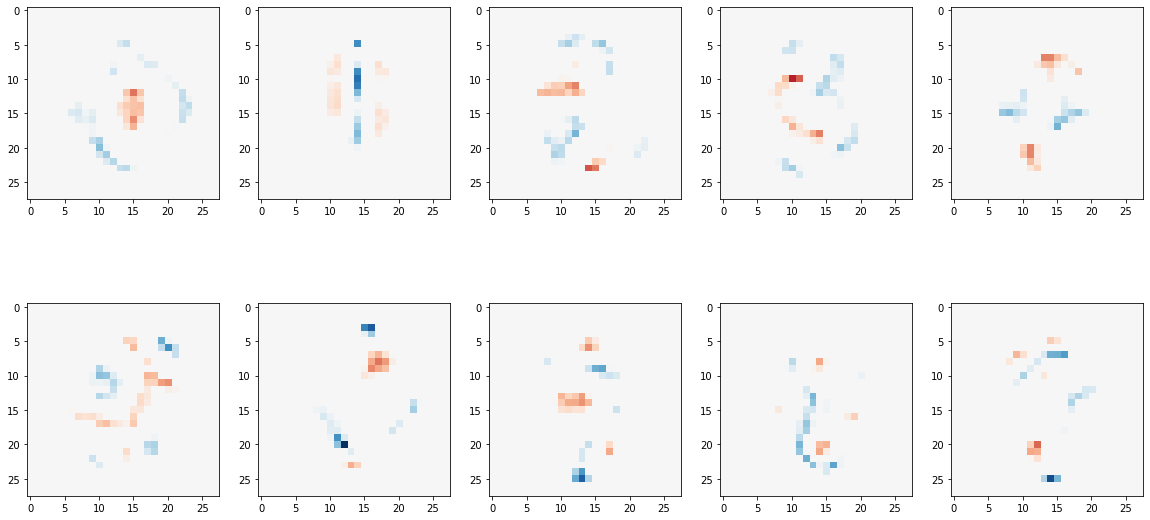

In [62]:
%%time

# Saga is chosen as the optimization algorithm as it is suitable for multiclass problems
# Turn up tolerance for faster convergence.
# Use l1 to increase the sparsity of the matrix, which helps in better classification

clf = LogisticRegression(C = 0.01, solver='saga', tol=0.1, penalty='l1')
clf.fit(train_min_max, train_labels)

predictions = clf.predict(test_min_max)

score = accuracy_score(test_labels, predictions)
sparsity = np.mean(clf.coef_ == 0) * 100

print(f'Sparsity of the matrix: {sparsity}')
print(f'Accuracy score with l1 penalty: {score}')
print(f'Classification vectors.. {print_classification_vector(clf.coef_.copy())}')

*With deskewing + denoising, the accuracy has come down from 93.78% to 91.11%*

In [63]:
# Plot gradient descend
# Plot learning curves, Cross validation curves
# Hyperparameter grid search

# clf.n_iter_
# clf.estimator.loss_curve_

We can see a huge improvement in the performance. The total-time taken to run the model has dropped to 15s from 3min 19s. Adding tolerence seems to have made the difference. Sparsity of the classification vectors has increased as well, which helps in better recognition of digits. Let us explore the confusion matrix to see if we can get some insights on the behaviour of our model.

## Testing output for sanity check

Let us do a sanity check to see how the images look for both correctly classified and misclassified predictions and see if we can uncover more from the samples.

In [64]:
# Getting indexes for both misclassified and correctly classified images

index = 0
misclassified_images = []
correctly_classified_images = []

for label, predict in zip(test_labels, predictions):
    if label == predict:
        correctly_classified_images.append(index)
    else:
        misclassified_images.append(index)
    index += 1

In [77]:
train_data = flatten_images(train_images)
test_data = flatten_images(test_images)

### Display correctly classified images

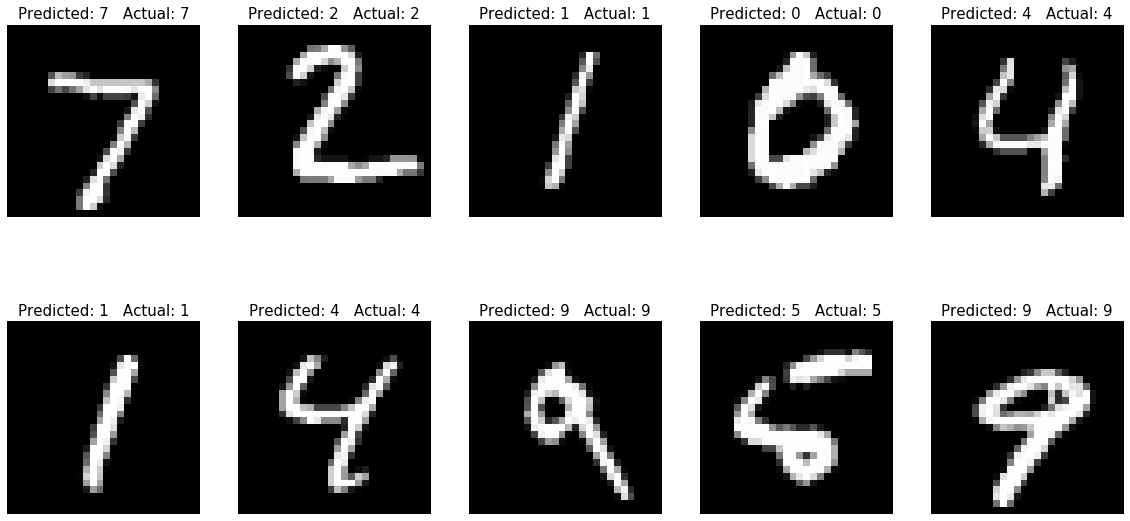

In [78]:
plt.figure(figsize=(20, 10))

for i, correctly_classified_index in enumerate(zip(correctly_classified_images[: 10])):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.reshape(test_data[correctly_classified_index], (28, 28)), cmap=plt.cm.gray)
    plt.title(f'Predicted: {predictions[correctly_classified_index]}   Actual: {test_labels[correctly_classified_index]}', 
              fontsize = 15)
    plt.axis('off')


From the above list, we can make out that the images that were correctly classified have a clear distinction,not too blurry. The model also identified few numbers that were slanting. For example: the number 9 in the last row.

### Display misclassified images

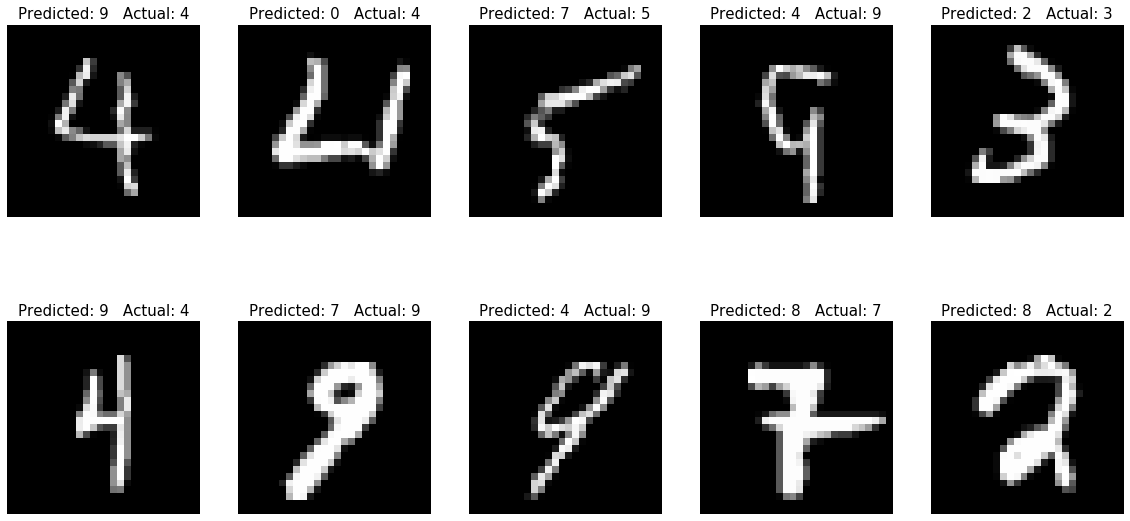

In [79]:
plt.figure(figsize=(20, 10))

i = 0
for misclassified_images_index in (misclassified_images[0:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(test_data[misclassified_images_index], (28, 28)), cmap=plt.cm.gray)
    plt.title(f'Predicted: {predictions[misclassified_images_index]}   Actual: {test_labels[misclassified_images_index]}', 
              fontsize = 15)
    plt.axis('off')
    i += 1

From the above, we can notice that most of the incorrectly classified digits are hand written, some numbers do not have clear shapes and are blurry. Let us see how the model is misclassifying for each digit.

#### Misclassified images for the digit 1

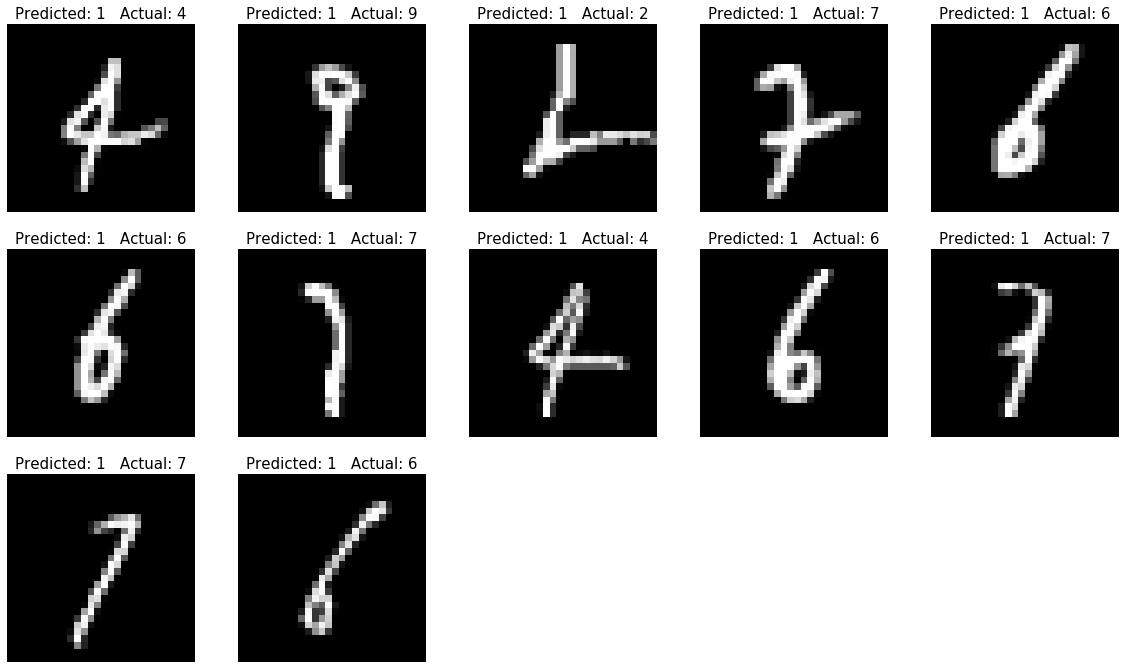

In [80]:
# A method that displays a list of misclassified images for a given number

def show_image(i, image_index):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(test_data[image_index], (28, 28)), cmap=plt.cm.gray)
    plt.title(f'Predicted: {predictions[image_index]}   Actual: {test_labels[image_index]}', 
              fontsize = 15)
    plt.axis('off')

# Displays images for a given number. 
# For ex: if 6 is passed as num, the method displays all images that were predicted as 6 
def display_images_for_number(predicted_list, num):
    plt.figure(figsize=(20, 20))

    i = 0
    for predicted_index in (predicted_list):
        if predictions[predicted_index] == num:
            show_image(i, predicted_index)
            i += 1
            
           
display_images_for_number(misclassified_images[0:250], 1)

Most of the images misclassified as 1 seem to have a  clear straight line

#### Misclassified images for the digit 2

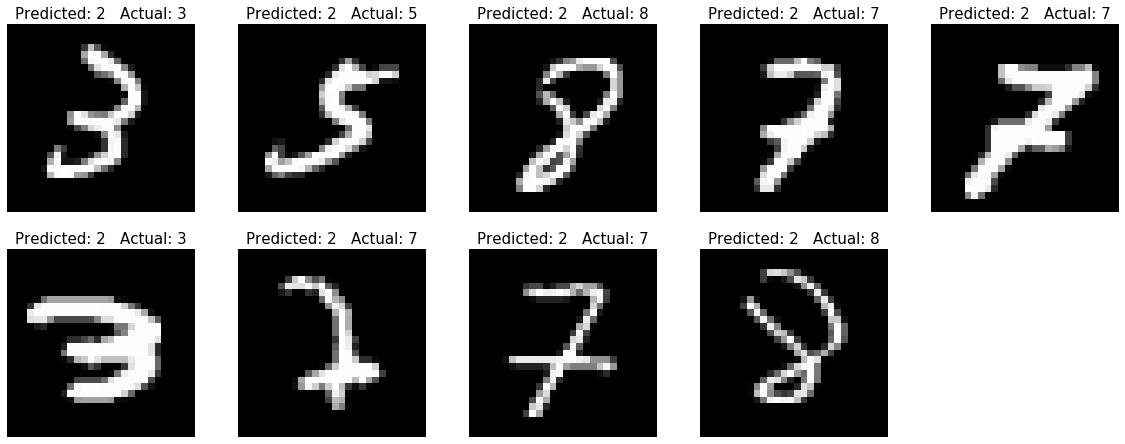

In [81]:
display_images_for_number(misclassified_images[0:200], 2)

A lot of 7's seem to be misclassified as 2

#### Misclassified images for the digit 3

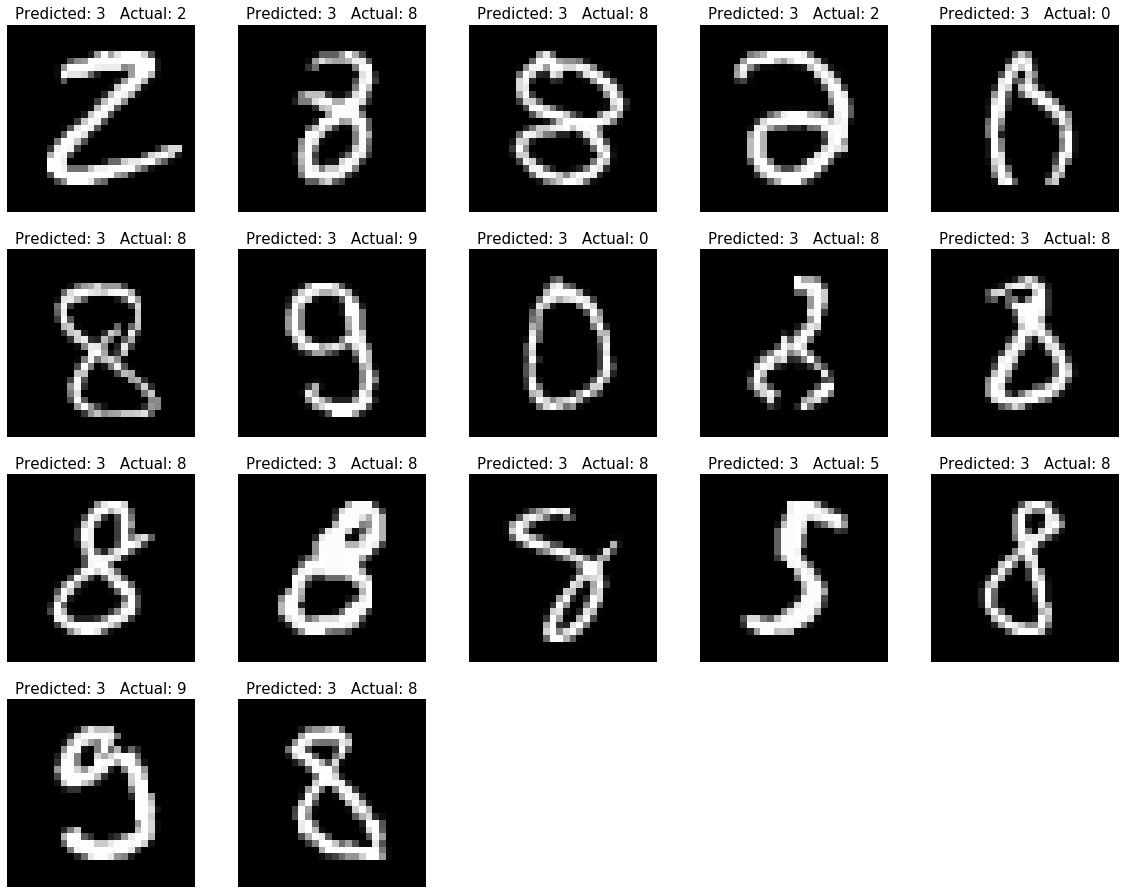

In [82]:
display_images_for_number(misclassified_images[0:150], 3)

No pattern other than slant and closely resembling images getting misclassified.

#### Misclassified images for the digit 4

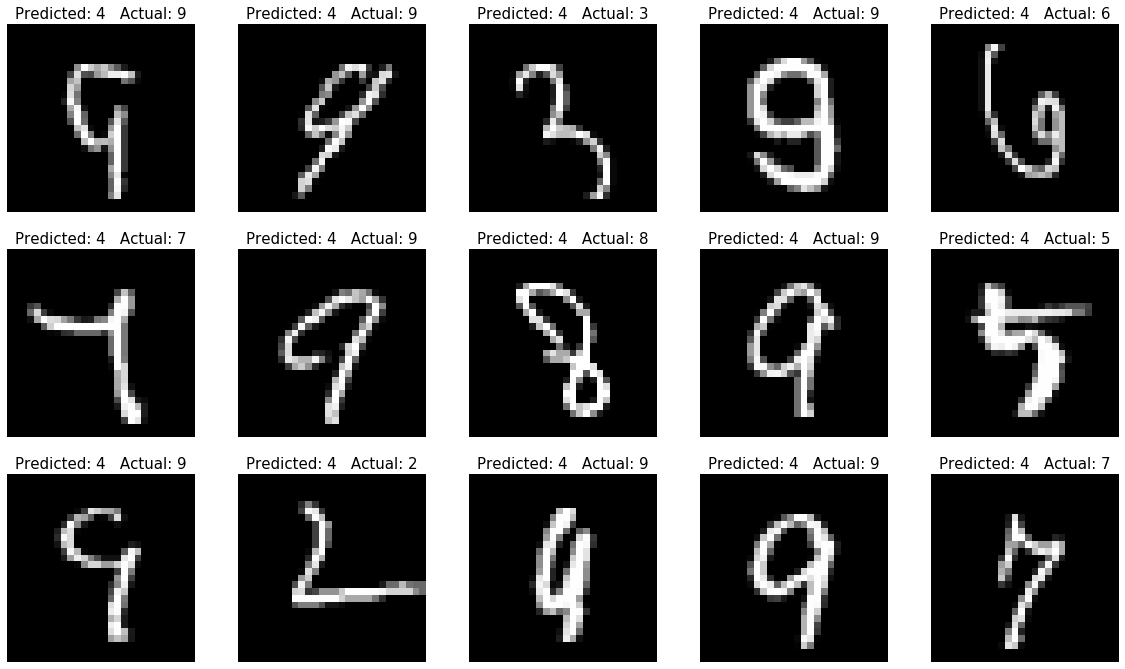

In [83]:
display_images_for_number(misclassified_images[0:150], 4)

No pattern other than slant, unclear and closely resembling images getting misclassified.

#### Misclassified images for the digit 5

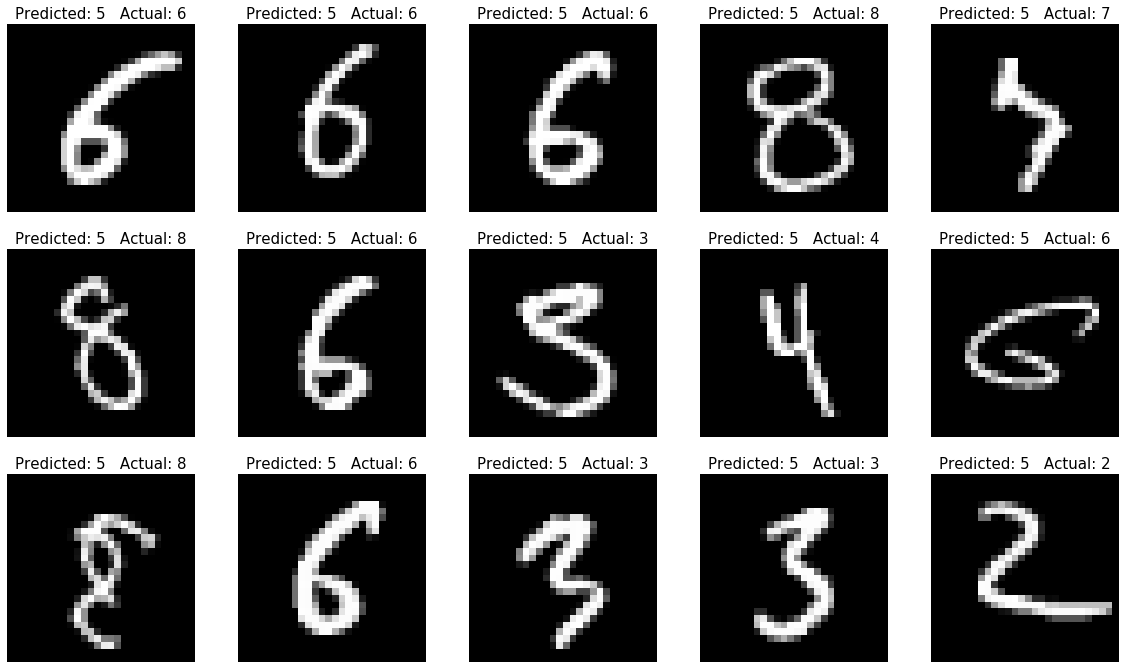

In [84]:
display_images_for_number(misclassified_images[0:150], 5)

The numbers seem to resemble the pattern 5 and also some are not very clear.

#### Misclassified images for the digit 6

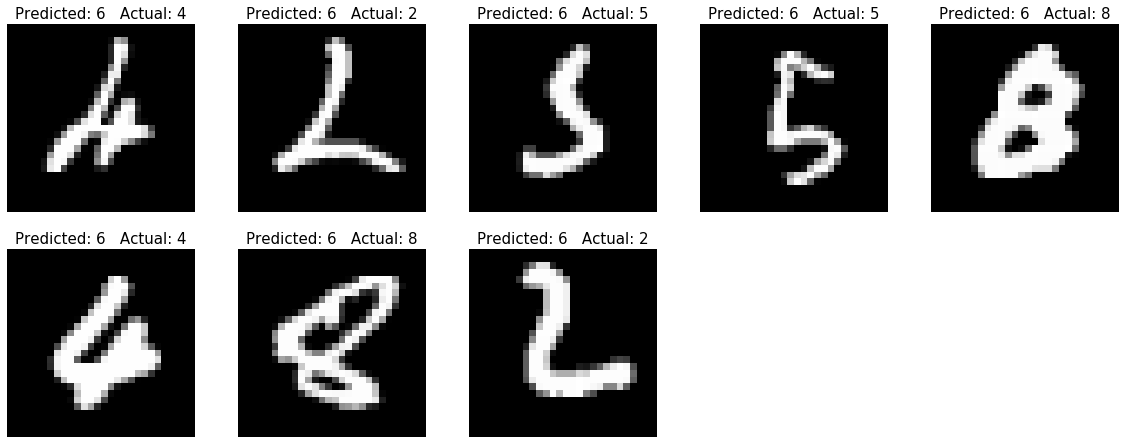

In [85]:
display_images_for_number(misclassified_images[0:150], 6)

A lot of letters that are thick and look similar to 6 seem to have been misclassified.

#### Misclassified images for the digit 7

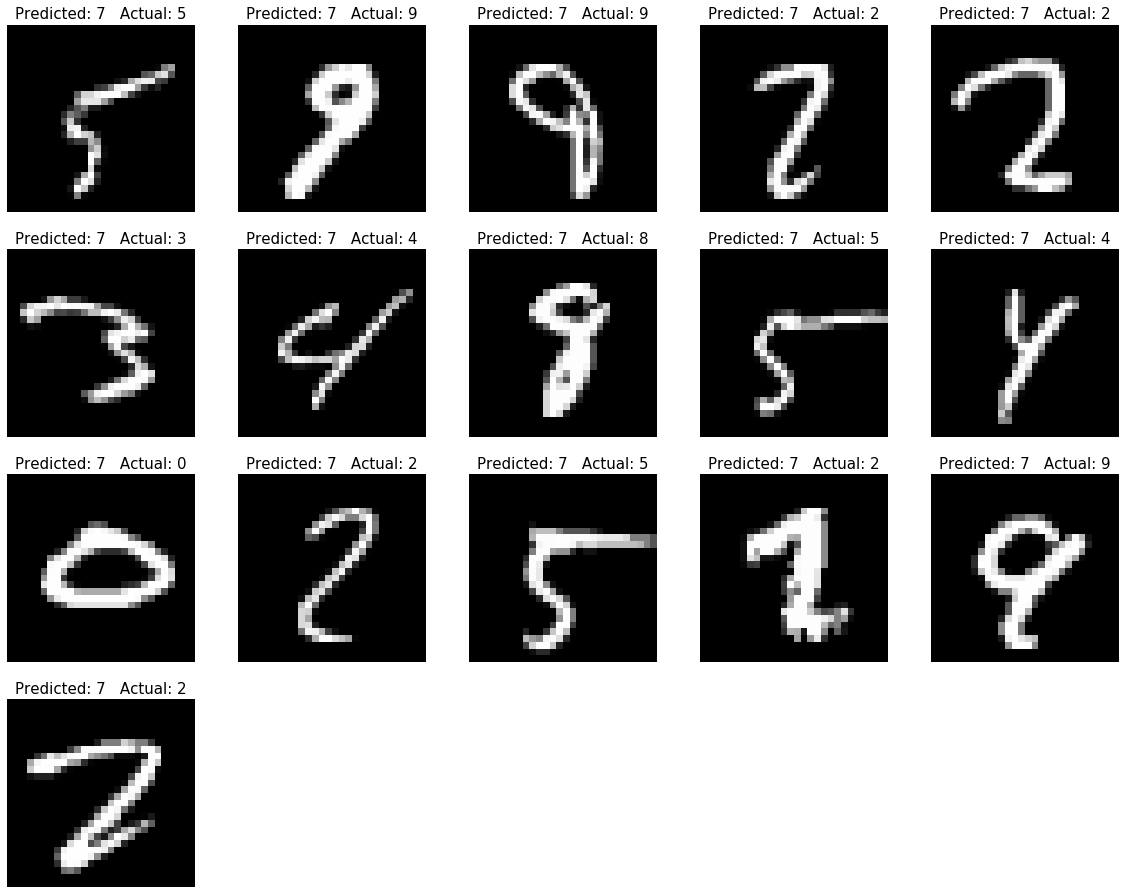

In [86]:
display_images_for_number(misclassified_images[0:100], 7)

It is interesting to see that 0, which has a clear distinction is being misclassified as 7. It could be because it looks like it is tilted by 90 degrees. May be we should train the model with images tilted in different directions.

#### Misclassified images for the digit 8

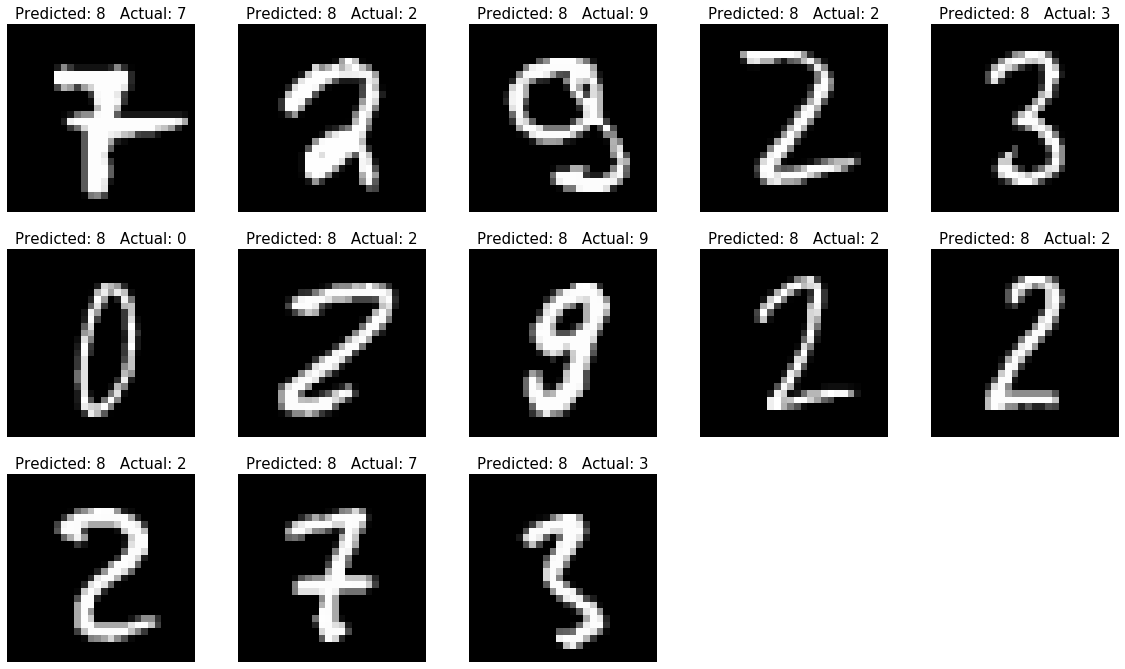

In [87]:
display_images_for_number(misclassified_images[0:100], 8)

It looks like all unclear handwritten digits are getting misclassified as 8

#### Misclassified images for the digit 9

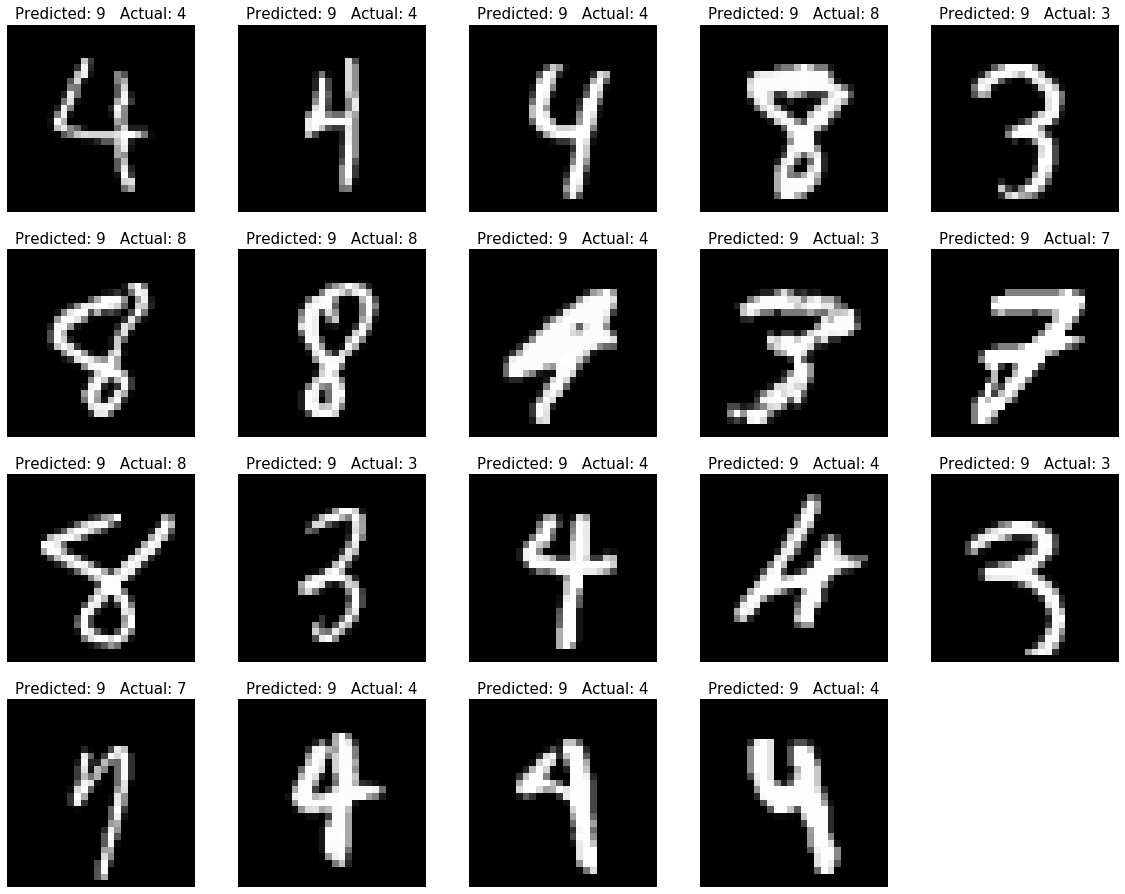

In [88]:
display_images_for_number(misclassified_images[0:100], 9)

Most of the 4's are getting misclassified as 9.

#### Misclassified images for the digit 0

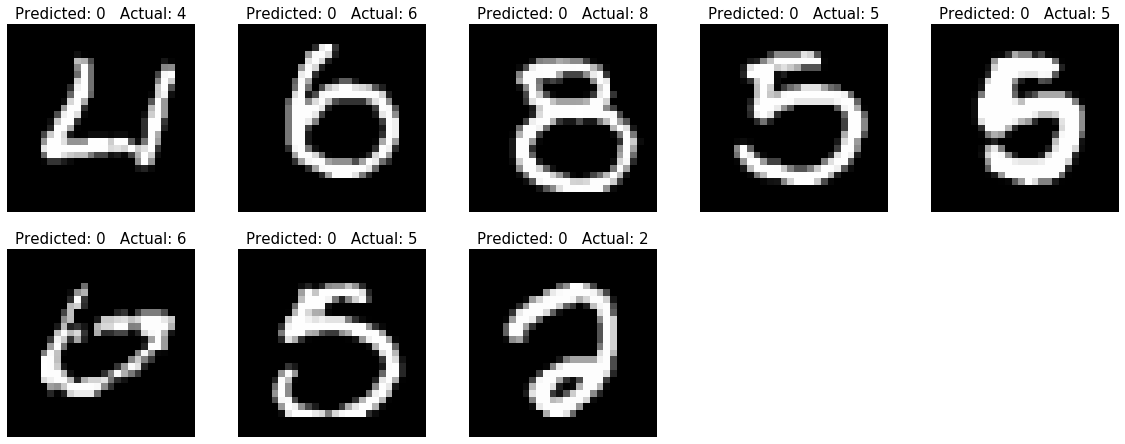

In [89]:
display_images_for_number(misclassified_images[0:100], 0)

Any number that resembles a zero is getting misclassified.

To summarize, we could do the following to help improve the model:

2. Blurry and very fat digits seem to get misclassified. Probably train model with more blurry images, deslanted and deskewed images.

References:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html
Confusion matrix: https://www.python-course.eu/confusion_matrix.php
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
Preprocessing
https://fsix.github.io/mnist/
Synthetic data generation:
https://towardsdatascience.com/synthetic-data-generation-a-must-have-skill-for-new-data-scientists-915896c0c1ae
https://towardsdatascience.com/do-you-need-synthetic-data-for-your-ai-project-e7ecc2072d6b
https://towardsdatascience.com/how-uber-uses-synthetic-data-to-speed-up-training-cc989c23ded4
